In [1]:
from Network.SSVAE.DGM import M2
import tensorflow as tf
import numpy as np
import pandas as pd
from Util import textcnn_util, dgm_utils
import parmas as par
import time
import nnst.nnst as nnst
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
ckpt_name = '../ckpt/ssvae_'+str(datetime.datetime.now().isoformat())+'.ckpt'

sess = tf.Session()

model = M2(
        dim_x=par.max_length * par.embedding_dim,
        dim_y=par.num_classes,
        dim_z=10,
        sess=sess
)

saver = tf.train.Saver(tf.global_variables())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Variables list is follow:
[<tf.Variable 'encoder/encoder_L1_W:0' shape=(6006, 500) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder_L1_b:0' shape=(500,) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder_L2_W:0' shape=(500, 20) dtype=float32_ref>,
 <tf.Variable 'encoder/encoder_L2_b:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'decoder/decoder_L1_W:0' shape=(16, 500) dtype=float32_ref>,
 <tf.Variable 'decoder/decoder_L1_b:0' shape=(500,) dtype=float32_ref>,
 <tf.Variable 'decoder/decoder_L2_W:0' shape=(500, 6000) dtype=float32_ref>,
 <tf.Variable 'decoder/decoder_L2_b:0' shape=(6000,) dtype=float32_ref>,
 <tf.Variable 'classifier_conv_var/window_conv_0/kernel:0' shape=(3, 400, 2) dtype=float32_ref>,
 <tf.Variable

In [3]:
w2v_model = '../w2v_model/nnst.model'
saver = tf.train.Saver(tf.global_variables())

data = nnst.load_data('../csv/nnst_news.csv')
labeled_set, unlabeled_set = nnst.div_dataset(data, 1500)

In [4]:
labeled_x = textcnn_util.proccessing_util(w2v_model).preprossessing(labeled_set[:,0],par.embedding_dim,par.max_length)
labeled_y = labeled_set[:,1].astype(int)

unlabeled_x = textcnn_util.proccessing_util(w2v_model).preprossessing(unlabeled_set[:,0],par.embedding_dim,par.max_length)
unlabeled_y = unlabeled_set[:,1].astype(int)


test_x = labeled_x[:500]
test_y = labeled_y[:500]


labeled_x = labeled_x[500:]
labeled_y = labeled_y[500:]

/usr/local/lib/python3.6/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [5]:
alpha = 0.1 * len(unlabeled_x) / len(labeled_y)
print('unlabeled : {}, labeled: {}'.format(len(unlabeled_x), len(labeled_y)))

unlabeled : 58500, labeled: 1000


In [6]:
prev_accuracy = 0
classifier_loss_history = []
labeled_loss_history = []
unlabeled_loss_history = []
eval_accuracy_history = []
for i in range(10000):
    rand_labeled = np.random.randint(labeled_y.shape[0], size=par.batch_size)
    rand_idx_unlabeled = np.random.randint(unlabeled_x.shape[0], size=par.batch_size )

    _, loss, classifier_loss, labeled_loss, unlabeled_loss = model.train(
            labeled=(labeled_x[rand_labeled], labeled_y[rand_labeled]),
            unlabeled=unlabeled_x[rand_idx_unlabeled],
            alpha=alpha
    )
    classifier_loss_history.append(classifier_loss)
    labeled_loss_history.append(labeled_loss)
    unlabeled_loss_history.append(unlabeled_loss)
    
    if i%100 == 0:
        print('-----------------')
        accuracy = model.eval(test_x,test_y)
        eval_accuracy_history.append(accuracy)
        print('epoch: {} \n'
                  'train loss: {} \n'
                  'train classifier loss: {} \n'
                  'train labeled loss: {} \n'
                  'train unlabeled loss: {} \n'
                  'eval_accuracy: {}'
                  .format(i,loss,classifier_loss, labeled_loss, unlabeled_loss, accuracy))
        print('-----------------')
        saver.save(sess, save_path=ckpt_name)

-----------------
epoch: 0 
train loss: -572.6329345703125 
train classifier loss: 2.754514694213867 
train labeled loss: -134.04827880859375 
train unlabeled loss: -454.6986083984375 
eval_accuracy: 0.156
-----------------
-----------------
epoch: 100 
train loss: -25581.900390625 
train classifier loss: 2.2921013832092285 
train labeled loss: -2489.911376953125 
train unlabeled loss: -23105.396484375 
eval_accuracy: 0.164
-----------------
-----------------
epoch: 200 
train loss: -79927.234375 
train classifier loss: 2.264878034591675 
train labeled loss: -6042.037109375 
train unlabeled loss: -73898.4453125 
eval_accuracy: 0.156
-----------------
-----------------
epoch: 300 
train loss: -151709.5625 
train classifier loss: 2.221083879470825 
train labeled loss: -10075.849609375 
train unlabeled loss: -141646.71875 
eval_accuracy: 0.16
-----------------
-----------------
epoch: 400 
train loss: -226664.5625 
train classifier loss: 2.1953117847442627 
train labeled loss: -14324.3505

-----------------
epoch: 4000 
train loss: -3659886.0 
train classifier loss: 1.8460763692855835 
train labeled loss: -208836.046875 
train unlabeled loss: -3451060.75 
eval_accuracy: 0.2
-----------------
-----------------
epoch: 4100 
train loss: -3760643.0 
train classifier loss: 1.8355063199996948 
train labeled loss: -214092.5 
train unlabeled loss: -3546561.25 
eval_accuracy: 0.196
-----------------
-----------------
epoch: 4200 
train loss: -3864397.25 
train classifier loss: 1.8250243663787842 
train labeled loss: -220036.9375 
train unlabeled loss: -3644371.0 
eval_accuracy: 0.196
-----------------
-----------------
epoch: 4300 
train loss: -3967552.75 
train classifier loss: 1.814579725265503 
train labeled loss: -225738.09375 
train unlabeled loss: -3741825.25 
eval_accuracy: 0.196
-----------------
-----------------
epoch: 4400 
train loss: -4071322.0 
train classifier loss: 1.8044694662094116 
train labeled loss: -231575.546875 
train unlabeled loss: -3839757.0 
eval_accur

-----------------
epoch: 8000 
train loss: -7897945.0 
train classifier loss: 1.4940913915634155 
train labeled loss: -441625.3125 
train unlabeled loss: -7456328.0 
eval_accuracy: 0.194
-----------------
-----------------
epoch: 8100 
train loss: -8010389.5 
train classifier loss: 1.4871912002563477 
train labeled loss: -448263.9375 
train unlabeled loss: -7562134.0 
eval_accuracy: 0.194
-----------------
-----------------
epoch: 8200 
train loss: -8118524.5 
train classifier loss: 1.479939579963684 
train labeled loss: -454108.28125 
train unlabeled loss: -7664424.5 
eval_accuracy: 0.198
-----------------
-----------------
epoch: 8300 
train loss: -8227956.5 
train classifier loss: 1.4727659225463867 
train labeled loss: -460449.625 
train unlabeled loss: -7767515.5 
eval_accuracy: 0.198
-----------------
-----------------
epoch: 8400 
train loss: -8330890.5 
train classifier loss: 1.464156150817871 
train labeled loss: -465240.9375 
train unlabeled loss: -7865658.0 
eval_accuracy: 0

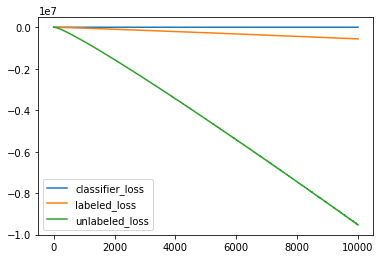

In [7]:
plt.plot(classifier_loss_history)
plt.plot(labeled_loss_history)
plt.plot(unlabeled_loss_history)
plt.legend(['classifier_loss','labeled_loss','unlabeled_loss'])
plt.show()

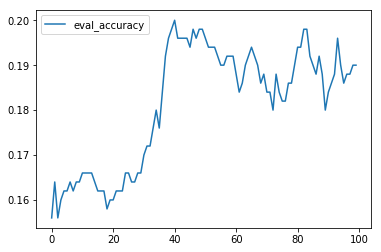

In [8]:
plt.plot(eval_accuracy_history)
plt.legend(['eval_accuracy'])
plt.show()

In [10]:
test_accuracy = model.eval(unlabeled_x,unlabeled_y)
print('test accuracy:', test_accuracy)

test accuracy: 0.19305982905982905
